In [1]:
%matplotlib inline

# Training Data Summary

In [2]:
import os
import re
import math

from collections import namedtuple, Counter
from glob import glob
from multiprocessing import Pool, freeze_support

import numpy as np
import wfdb

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from wfdb import processing

## Initial Data

The [data for this Challenge](https://physionetchallenges.github.io/2020/#-data) comes from multiple sources:

1. Southeast University, China, including the data from the China Physiological Signal Challenge 2018
2. Centre for Cardiometabolic Risk Reduction in South-Asia (CARRS), India
3. A diverse population in the USA.

This full dataset has not been released yet.
The initial data provided is the public data used in the [China Physiological Signal Challenge in 2018 (CPSC2018)](http://2018.icbeb.org/).
It contains:

* 6,877 records (male: 3,699, female: 3,178)
* 12-lead ECG recordings ranging from 6 to 60 seconds
* Sampled at 500Hz
* Age, Diagnosis at the end of header file


In [3]:
record_names = [fn.split(".hea")[0] for fn in glob("Training_WFDB/*.hea")]
num_records = len(record_names)
print("num records:", num_records)


num records: 6877


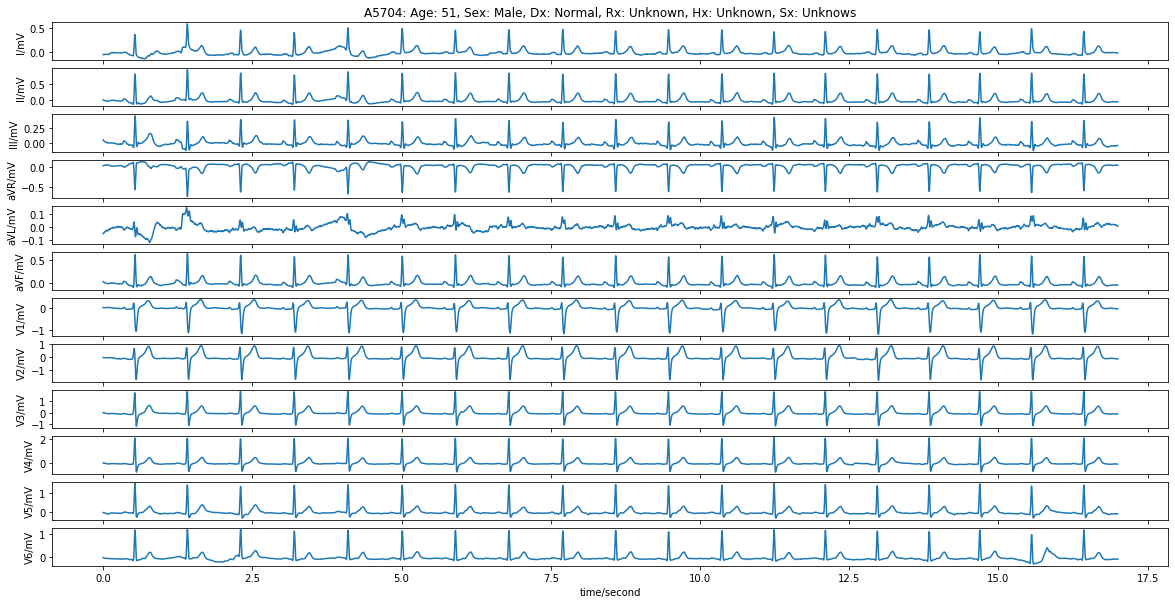

record_name: A5704
n_sig: 12
fs: 500
counter_freq: None
base_counter: None
sig_len: 8500
base_time: 00:00:05
base_date: None
comments: ['Age: 51', 'Sex: Male', 'Dx: Normal', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknows']
sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
p_signal: [[-0.049  0.     0.05  ... -0.017 -0.044 -0.01 ]
 [-0.049 -0.002  0.048 ... -0.021 -0.046 -0.011]
 [-0.047 -0.004  0.044 ... -0.025 -0.049 -0.012]
 ...
 [-0.019 -0.059 -0.039 ... -0.116 -0.113 -0.074]
 [-0.019 -0.059 -0.039 ... -0.117 -0.114 -0.073]
 [-0.02  -0.059 -0.038 ... -0.118 -0.113 -0.071]]
d_signal: None
e_p_signal: None
e_d_signal: None
file_name: ['A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat', 'A5704.mat']
fmt: ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
samps_per_frame: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
skew: [None, None, None, None, None,

In [4]:
# show what one record looks like
record = wfdb.rdrecord(record_names[0])
wfdb.plot_wfdb(
    record=record, figsize=(20,10),
    time_units="seconds", title="{}: {}".format(record.record_name, ", ".join(record.comments)))
for k, v in record.__dict__.items():
    print(f"{k}: {v}")

## Initial Data Distribution

In [5]:
Meta = namedtuple("Meta", ("duration", "age", "sex", "Dx"))
labels = ("Normal", "AF", "I-AVB", "LBBB", "RBBB", "PAC", "PVC", "STD", "STE")

def derive_meta(rn):
    r = wfdb.rdrecord(rn)
    key = r.record_name

    # data hygiene, check match challenge description
    assert len(r.p_signal) == r.sig_len, f"{key} sig_len mismatch"
    assert r.n_sig == 12, f"{key} n_sig not 12-lead"
    assert all(len(l) == r.n_sig for l in r.p_signal), f"{key} p_signal not 12-lead"
    assert r.fs == 500, f"{key} not 500Hz"
    assert r.sig_name == ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    assert r.fmt == ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
    assert r.samps_per_frame == [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    assert r.skew == [None, None, None, None, None, None, None, None, None, None, None, None]
    assert r.byte_offset == [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
    assert r.adc_gain == [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
    assert r.baseline == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.units == ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']
    assert r.adc_res == [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    assert r.adc_zero == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.block_size == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # parse out age, sex, diagnosis from comments
    assert len(r.comments) == 6, f"{key} header comments invalid"
    raw_age, raw_sx, raw_dx, _rx, _hx, _sx = r.comments
    age_grp = re.search(r"^Age: (?P<age>.*)$", raw_age)
    assert age_grp is not None, f"{key} no age defined: {raw_age}"
    age = float(age_grp.group("age"))
    if math.isnan(age):
        age = -1

    sx_grp = re.search(r"^Sex: (?P<sx>.*)$", raw_sx)
    assert sx_grp is not None, f"{key} no sex defined: {raw_sx}"
    sex = sx_grp.group("sx")
    assert sex in ("Male", "Female"), f"{key} not male/female: {sex}"
    dx_grp = re.search(r"^Dx: (?P<dx>.*)$", raw_dx)
    assert dx_grp is not None, f"{key} no Dx defined: {raw_dx}"
    dx = dx_grp.group("dx").split(",")
    assert all(d in labels for d in dx), f"{key} label mismatch: {dx}"

    duration = r.sig_len/r.fs

    return key, Meta(duration, age, sex, dx)


In [6]:
metas = {}
# single process approach
# for record_name in tqdm(record_names, desc="Record"):
#     key, meta = derive_meta(record_name)
#     metas[key] = meta

# multiprocess approach
try:
    procs = len(os.sched_getaffinity(0))
except:
    procs = 1

with tqdm(record_names, desc="Record") as t:
    with Pool(procs, initializer=tqdm.set_lock,
              initargs=(tqdm.get_lock(),)) as p:
        metas = dict(p.imap_unordered(derive_meta, t))


### ECG Recording Lengths

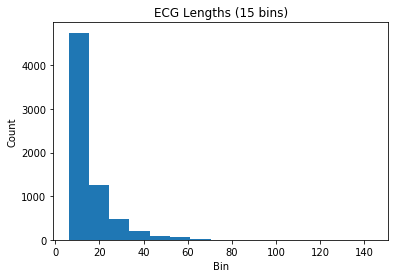

  6.0s: 4746 records
 15.2s: 1259 records
 24.4s: 466 records
 33.6s: 212 records
 42.8s: 95 records
 52.0s: 73 records
 61.2s: 9 records
 70.4s: 5 records
 79.6s: 2 records
 88.8s: 2 records
 98.0s: 2 records
107.2s: 1 records
116.4s: 2 records
125.6s: 1 records
134.8s: 2 records


In [7]:
bins = 15
plt.title(f"ECG Lengths ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

durations = [m.duration for m in metas.values()]
count_vals, bin_vals, _ = plt.hist(durations, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>5.1f}s: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(durations)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Recording Patient Age

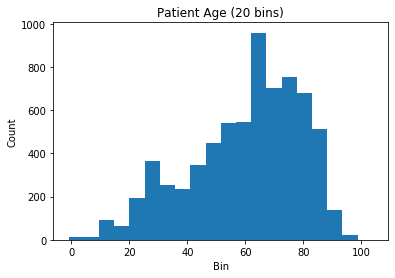

-1 yrs: 13 records
 4 yrs: 11 records
10 yrs: 91 records
15 yrs: 62 records
20 yrs: 192 records
25 yrs: 365 records
30 yrs: 254 records
36 yrs: 234 records
41 yrs: 348 records
46 yrs: 447 records
52 yrs: 542 records
57 yrs: 546 records
62 yrs: 959 records
67 yrs: 702 records
72 yrs: 755 records
78 yrs: 681 records
83 yrs: 513 records
88 yrs: 140 records
94 yrs: 21 records
99 yrs: 1 records


In [8]:
bins = 20
plt.title(f"Patient Age ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

ages = [m.age for m in metas.values()]
count_vals, bin_vals, _ = plt.hist(ages, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>2.0f} yrs: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(ages)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Diagnosis Distribution

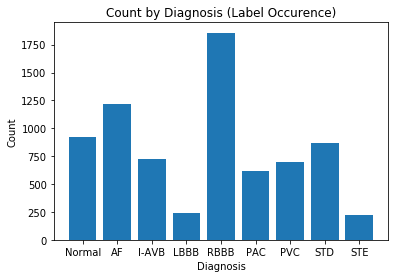

Label Occurences
Normal: (13.3%) 918 records
    AF: (17.8%) 1221 records
 I-AVB: (10.5%) 722 records
  LBBB: ( 3.4%) 236 records
  RBBB: (27.0%) 1857 records
   PAC: ( 9.0%) 616 records
   PVC: (10.2%) 700 records
   STD: (12.6%) 869 records
   STE: ( 3.2%) 220 records


In [9]:
flat_dx = [dx for m in metas.values() for dx in m.Dx]
dx_counter = Counter(flat_dx)

plt.title("Count by Diagnosis (Label Occurence)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.bar(labels, list(dx_counter[l] for l in labels))
bottom, top = plt.ylim()
plt.show()

print("Label Occurences")
for label in labels:
    pct = 100 * dx_counter[label] / num_records
    print("{:>6}: ({:>4.1f}%) {} records".format(label, pct, dx_counter[label]))

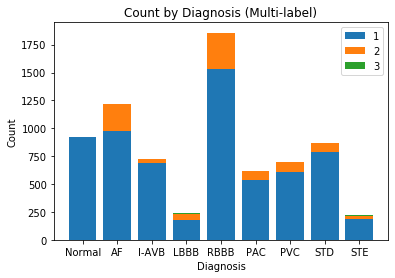

Multi-Label Occurences
           RBBB: (22.29%) 1533 records
             AF: (14.19%) 976 records
         Normal: (13.35%) 918 records
            STD: (11.40%) 784 records
          I-AVB: ( 9.98%) 686 records
            PVC: ( 8.83%) 607 records
            PAC: ( 7.75%) 533 records
            STE: ( 2.69%) 185 records
           LBBB: ( 2.60%) 179 records
       AF, RBBB: ( 2.50%) 172 records
      PAC, RBBB: ( 0.76%) 52 records
      PVC, RBBB: ( 0.74%) 51 records
        AF, STD: ( 0.44%) 30 records
       AF, LBBB: ( 0.38%) 26 records
      RBBB, STD: ( 0.29%) 20 records
       PVC, STD: ( 0.26%) 18 records
      RBBB, STE: ( 0.23%) 16 records
    I-AVB, RBBB: ( 0.15%) 10 records
      LBBB, PAC: ( 0.15%) 10 records
    I-AVB, LBBB: ( 0.12%) 8 records
        AF, PVC: ( 0.12%) 8 records
      LBBB, PVC: ( 0.09%) 6 records
     I-AVB, STD: ( 0.09%) 6 records
       PAC, STD: ( 0.09%) 6 records
     I-AVB, PVC: ( 0.07%) 5 records
     I-AVB, STE: ( 0.06%) 4 records
      LBBB,

In [10]:
plt.title("Count by Diagnosis (Multi-label)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")

prv_count = [0,] * len(labels)
plts = {}
for i in range(1, len(labels)):
    nested_dx = [dx for m in metas.values() for dx in m.Dx if len(m.Dx) == i]
    if not nested_dx:
        continue
    dx_counter = Counter(nested_dx)
    count = list(dx_counter[l] for l in labels)
    plts[i] = plt.bar(labels, count, bottom=prv_count)
    prv_count = list(sum(c) for c in zip(prv_count, count))

plt.ylim(bottom, top)
plt.legend(plts.values(), plts.keys())
plt.show()

dx_counter = Counter([", ".join(sorted(m.Dx)) for m in metas.values()])
print("Multi-Label Occurences")
for key, count in sorted(dx_counter.items(), key=lambda i: i[1], reverse=True):
    pct = 100 * count / num_records
    print("{:>15}: ({:>5.2f}%) {} records".format(key, pct, count))


## WFDB QRS Detection Algorithms

The WFDB library provides helper processors (like [XQRS](https://wfdb.readthedocs.io/en/latest/processing.html#wfdb.processing.XQRS)) for generating annotations. 

In [11]:
wfdb.show_ann_labels()
wfdb.show_ann_classes()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [12]:
def xqrs_detect(record_name):
    sig_qrs_inds = []
    for channel in range(12):
        sig, fields = wfdb.rdsamp(record_name, channels=[channel])

        sig_qrs_inds.append(processing.xqrs_detect(
            sig=sig[:,0], sampfrom=0, sampto="end", fs=fields["fs"],
            learn=False, verbose=False))

    avg_sig_qrs_inds = np.array(
        [int(sum(e) / len(e)) for e in zip(
            *[a for a in sig_qrs_inds if len(a)])])
    return sig_qrs_inds, avg_sig_qrs_inds


In [13]:
record = wfdb.rdrecord(record_names[0])
sig_ann, sig_avg_ann = xqrs_detect(record_names[0])

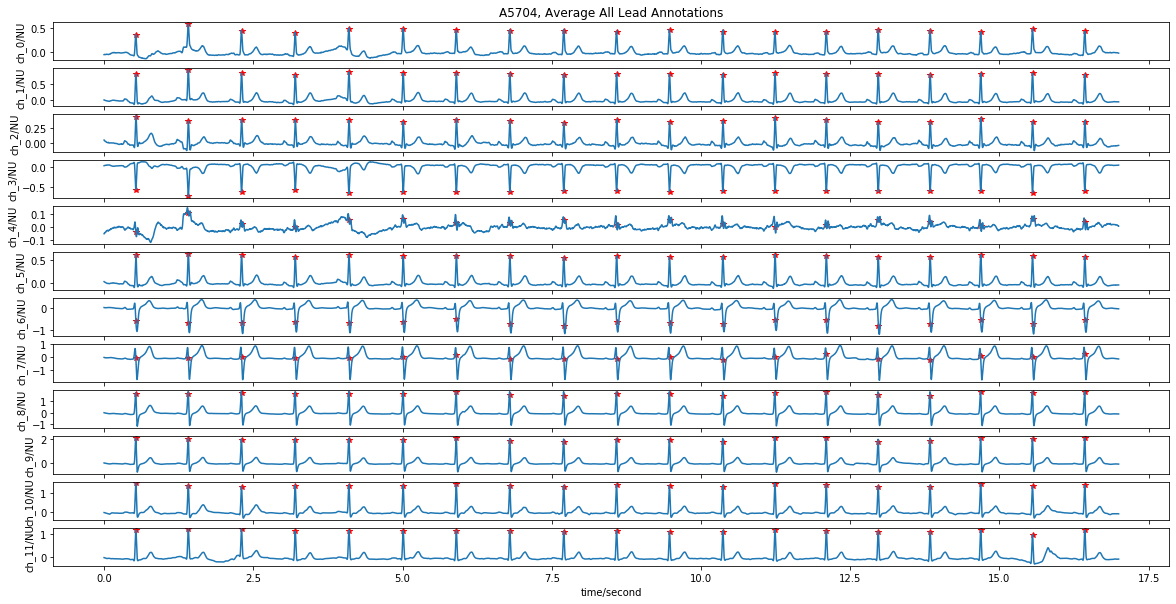

In [14]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=[sig_avg_ann,] * 12,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}, Average All Lead Annotations".format(record.record_name))

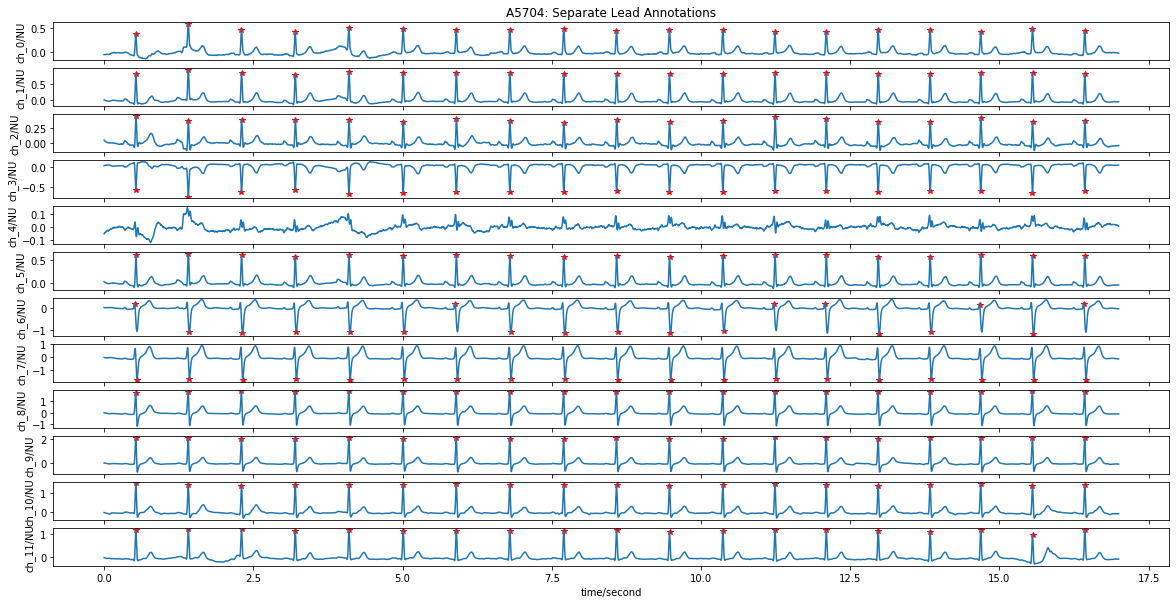

In [15]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=sig_ann,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}: Separate Lead Annotations".format(record.record_name))

19 reference annotations, 19 test annotations

True Positives (matched samples): 19
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 0

Specificity: 1.0000 (19/19)
Positive Predictivity: 1.0000 (19/19)
False Positive Rate: 0.0000 (0/19)


/home/alexander/sandbox/src/git.udia.ca/alex/physionet-challenge-2020/venv/lib/python3.7/site-packages/wfdb/processing/evaluate.py:328: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


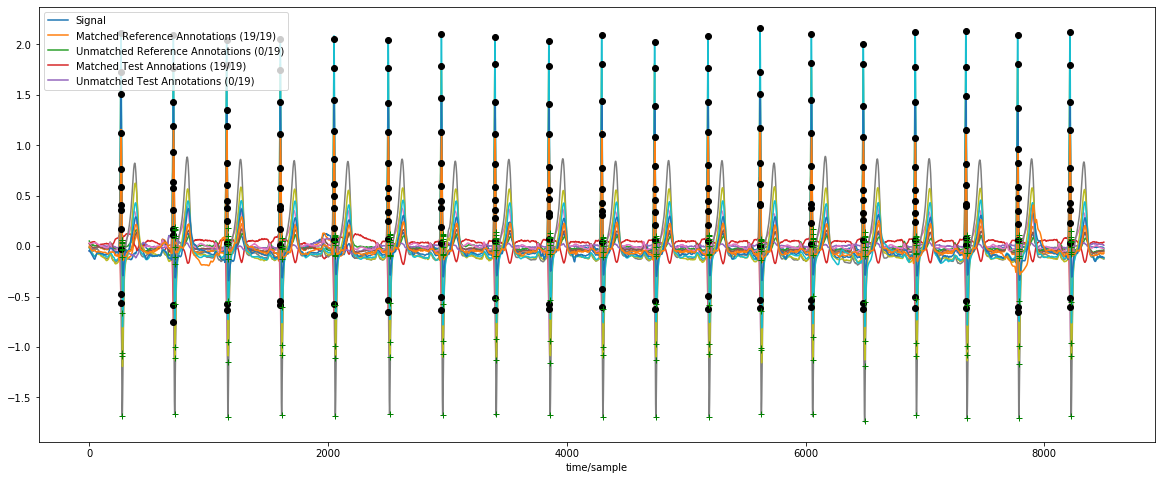

In [16]:
comparitor = processing.Comparitor(sig_ann[0], sig_ann[7], int(0.1 * record.fs), record.p_signal)
comparitor.compare()
comparitor.print_summary()
comparitor.plot(figsize=(20,8))